# Spiking 2014 based on Strength_one external pop

In [1]:
from brian2 import *
%matplotlib inline
import numpy as np
import seaborn as sns

# parameters

In [2]:
#Discretinize the space
N=20#number of populations or angles,标号为 0,1,...,N-1
dx=2*pi/N
x=linspace(-pi,pi-dx,N)  #the angle for each population
#Number for of exitatory, inhibitory and external neurons:
# NE=16000
# NI=4000
# NO=20000
k=1000
NE=4*k
NI=1*k
NO=5*k


########time constant#######
#for each neuron
TE=20*ms
TI=10*ms

#resting potential
VL=0

#for synaptic variable(including NMDA and AMPA)
TEI=TII=10*ms
TEE_N=150*ms
TEE_A=50*ms
TIE_N=45*ms
TIE_A=20*ms
TEO=100*ms
#scaling of probability
rou_E=0.2
rou_I=0.4
rou_O=0.2
#strength(大小，最终还有正负号) 且用数目和概率做一个scaling
J = 100
JEE = 1*J/sqrt(NE*rou_E)
JIE = 2*J/sqrt(NE*rou_E)
JEI = 1*J/sqrt(NI*rou_I)
JII = 2*J/sqrt(NI*rou_I)
JEO = 1*J/sqrt(NO*rou_O)
#proportion of NMDA and AMPA
q_EE_N=0.5
q_EE_A=0.5
q_IE_N=0.2
q_IE_A=0.8

# Probability

In [3]:
#Probability
# P_EI[i][j]: 从第j个population(角度为-pi+j*dx,j从0到N-1)的I连接上第i个popuation的E的概率
# 并且假设P_EI[i,j]=P_II[i,j],另一个同理 是0-1之间的数字

#probability
#本质上是N*N矩阵
P_IE=[np.zeros(N) for y in range(N)]
P_EE=[np.zeros(N) for y in range(N)]
P_II=[np.zeros(N) for y in range(N)]
P_EI=[np.zeros(N) for y in range(N)]
P_EO=np.zeros(N)#O以指数的方式连在G_E上面  P_EO[0]表示O到第1个population的E

for i in range(N):
    if i <= N//2:
        P_IE[0][i]=P_EE[0][i]=rou_E*exp(-(i*dx/(pi*0.25))**2)
        P_II[0][i]=P_EI[0][i]=rou_I*exp(-(i*dx/(pi*0.2))**2)
        P_EO[i] = rou_O*exp(-(i*dx/(pi*0.2))**2)
    else:
        P_IE[0][i]=P_EE[0][i]=rou_E*exp(-((N-i)*dx/(pi*0.25))**2)
        P_II[0][i]=P_EI[0][i]=rou_I*exp(-((N-i)*dx/(pi*0.2))**2)
        P_EO[i] = rou_O*exp(-((N-i)*dx/(pi*0.2))**2)
        
for i in range(N-1):
    P_IE[i+1]=np.roll(P_IE[i],1)
    P_EE[i+1]=np.roll(P_EE[i],1)
    P_II[i+1]=np.roll(P_II[i],1)
    P_EI[i+1]=np.roll(P_EI[i],1)

# create neurons and populations

In [4]:
#population size
pop_size=(NE+NI)/N
#proportion of excitatory and inhibitory neurons
prop_E=NE/(NE+NI)
prop_I=1-prop_E
#group size: group指同一population,同I或者E
group_E_size=pop_size*prop_E
group_I_size=pop_size*prop_I

#下面的VL在上方需要更改单位！！
#还没有加上external
eqs='''
dv/dt=(-v+VL+con_E-con_I+con_O)/tau_neuron:1 (unless refractory)
tau_neuron:second
con_E:1
con_I:1
con_O:1'''
#define all neurons in one group
G=NeuronGroup(NE+NI,eqs,threshold="v>1",reset="v=0",refractory=2*ms, method='exact')

#G的前面prop_E均为E,并将它们分成N等分作为不同的group.后面的均为I

#list of subgroup
#G_E[0]是第0个population的E
G_E = [None for x in range(N)]
G_I = [None for x in range(N)]
for j in range(N):
    G_E[j] = G[int(j*group_E_size):int((j+1)*group_E_size)]
    G_I[j] = G[int(N*group_E_size+j*group_I_size):int(N*group_E_size+(j+1)*group_I_size)]
    
exc_G = G[0:int(N*group_E_size)]
inh_G = G[int(N*group_E_size):NE+NI]
#parameters:tau_neuron
G.tau_neuron[0:int(N*group_E_size)]=TE
G.tau_neuron[int(N*group_E_size):]=TI
#Initial values:
G.v[:]=[uniform(0,1) for i in range(NI+NE)]


# Synapses

In [5]:
#syn_E_I[2]代表整个G_E到第二个population的I的所有synapsis
syn_E_I = [None for x in range(N)]
syn_E_E = [None for x in range(N)]
syn_I_I = [None for x in range(N)]
syn_I_E = [None for x in range(N)]

#equations for synapses from inhibitory neurons
eqs_I='''
ds/dt=-s/tau:1 (clock-driven)
tau:second
J:1
w:1
con_I_post=J*s:1 (summed)
'''
#equations for synapses from inhibitory neurons
#q: proportion of NMDA
eqs_E='''
ds_N/dt=-s_N/tau_N:1 (clock-driven)
ds_A/dt=-s_A/tau_A:1 (clock-driven)
tau_N:second
tau_A:second
J:1
q:1
w_N:1
w_A:1
con_E_post=J*q*s_N+J*(1-q)*s_A:1 (summed)
'''

#手动添加synapses:
net=Network(collect())

for j in range(N):
    syn_E_I[j] = Synapses(exc_G,G_I[j],eqs_E,on_pre='''s_N+=w_N
        s_A+=w_A''',method="exact")
    syn_E_E[j] = Synapses(exc_G,G_E[j],eqs_E,on_pre='''s_N+=w_N
        s_A+=w_A''',method="exact")
    syn_I_I[j] = Synapses(inh_G,G_I[j],eqs_I,on_pre="s+=w",method="exact")
    syn_I_E[j] = Synapses(inh_G,G_E[j],eqs_I,on_pre="s+=w",method="exact")
    
    for k in range(N):   
        syn_E_I[j].connect(condition="i>=%d and i<%d"%(k*group_E_size,(k+1)*group_E_size),
                                    p=P_IE[j][k] if P_IE[j][k]>0.000001 else 0 )
        syn_E_E[j].connect(condition="i>=%d and i<%d"%(k*group_E_size,(k+1)*group_E_size),
                                    p=P_EE[j][k] if P_EE[j][k]>0.000001 else 0)
        syn_I_I[j].connect(condition="i>=%d and i<%d"%(k*group_I_size,(k+1)*group_I_size),
                                    p=P_II[j][k] if P_II[j][k]>0.000001 else 0)
        syn_I_E[j].connect(condition="i>=%d and i<%d"%(k*group_I_size,(k+1)*group_I_size),
                                    p=P_EI[j][k] if P_EI[j][k]>0.000001 else 0)
        
    syn_E_I[j].tau_N = TIE_N
    syn_E_I[j].tau_A = TIE_A
    syn_E_I[j].J = JIE
    syn_E_I[j].q = q_IE_N
    syn_E_I[j].w_N = 1/(TIE_N/ms)
    syn_E_I[j].w_A = 1/(TIE_A/ms)
    
    syn_E_E[j].tau_N = TEE_N
    syn_E_E[j].tau_A = TEE_A
    syn_E_E[j].J = JEE
    syn_E_E[j].q = q_EE_N
    syn_E_E[j].w_N = 1/(TEE_N/ms)
    syn_E_E[j].w_A = 1/(TEE_A/ms)
    
    syn_I_I[j].tau = TII
    syn_I_I[j].J = JII
    syn_I_I[j].w = 1/(TII/ms)
    
    syn_I_E[j].tau = TEI
    syn_I_E[j].J = JEI
    syn_I_E[j].w = 1/(TEI/ms)
        
    net.add(syn_E_I[j])
    net.add(syn_E_E[j])
    net.add(syn_I_I[j])
    net.add(syn_I_E[j])
    
    

WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 is required. Get it with "Microsoft Visual C++ Build Tools": http://landinghub.visualstudio.com/visual-cpp-build-tools (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]
WARNING    "i" is an internal variable of group "synapses", but also exists in the run namespace with the value 18. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "i" is an internal variable of group "synapses_1", but also exists in the run namespace with the value 18. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WAR

WARNING    "i" is an internal variable of group "synapses_37", but also exists in the run namespace with the value 18. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "i" is an internal variable of group "synapses_38", but also exists in the run namespace with the value 18. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "i" is an internal variable of group "synapses_39", but also exists in the run namespace with the value 18. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "i" is an internal variable of group "synapses_40", but also exists in the run namespace with the value 18. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "i" is an internal variable of group "synapses_41", but also exists in the run namespace with the value 18. The internal variable will be used. [

WARNING    "i" is an internal variable of group "synapses_76", but also exists in the run namespace with the value 18. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "i" is an internal variable of group "synapses_77", but also exists in the run namespace with the value 18. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "i" is an internal variable of group "synapses_78", but also exists in the run namespace with the value 18. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "i" is an internal variable of group "synapses_79", but also exists in the run namespace with the value 18. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


# Simulation

In [6]:
#第一阶段，仅仅是让neuron fire起来
dec_time_1=0*ms
sti_time_1=30*ms
mem_time_1=100*ms
#第二阶段是真正的实验阶段
dec_time_2=0*ms
sti_time_2=100*ms
mem_time_2=2000*ms

External input(此时并没有包含在net里面)

In [7]:
#为external neuron做的一个filter,让tares慢慢的上去
def rate_fun(t,A):
    return (1-np.exp(-t/50)) *A * Hz
TA = TimedArray([rate_fun(t,40) for t in arange(0,1000,0.5)], dt=0.5*ms)

In [8]:
###External neurons###
P=PoissonGroup(NO,rates="TA(t)")  #rates= 40Hz
eqs_O='''
ds/dt = -s/tau_O :1 (clock-driven)
tau_O: second
J:1
w:1
con_O_post = J*s : 1 (summed)'''

#O以exp的方式连在整个G的E上，其中连到G_E[0]的概率是最大的
syn_O = Synapses(P,exc_G,eqs_O,on_pre="s+=w",method="exact")
for k in range(N):   
        syn_O.connect(condition="j>=%d and j<%d"%(k*group_E_size,(k+1)*group_E_size),
                                    p=P_EO[k] if P_EO[k]>0.000001 else 0 )
# syn_O.connect(p=rou_O)
syn_O.J=JEO
syn_O.w=1/(TEO/ms)
syn_O.tau_O=TEO 


#Another external neuron group
#先运行上面一个让network fire，再运行这一个看结果
P_=PoissonGroup(NO,rates="TA(t)")  #rates= 40Hz
#O连在某一个population的E上面
syn_O_ = Synapses(P_,exc_G,eqs_O,on_pre="s+=w",method="exact")
for k in range(N):   
        syn_O_.connect(condition="j>=%d and j<%d"%(k*group_E_size,(k+1)*group_E_size),
                                    p=P_EO[k] if P_EO[k]>0.000001 else 0 )
# syn_O_.connect(p=rou_O)
syn_O_.J=JEO
syn_O_.w=1/(TEO/ms)
syn_O_.tau_O=TEO 

各种monitor

In [9]:
statemon_G = StateMonitor(G, 'v', record=True)
net.add(statemon_G)
spikemon_G=SpikeMonitor(G)
net.add(spikemon_G) 
#最关注的是某一个group的firing rate
ratemon_E=[None for i in range(N)]
for i in range(N):
    ratemon_E[i]=PopulationRateMonitor(G_E[i])
    net.add(ratemon_E[i])
ratemon_G = PopulationRateMonitor(G)
net.add(ratemon_G)
ratemon_I = PopulationRateMonitor(inh_G)
net.add(ratemon_I)

###for testing
statemon_G_con_I = StateMonitor(G, 'con_I', record=True)
statemon_G_con_E = StateMonitor(G, 'con_E', record=True)
statemon_G_con_O = StateMonitor(G, 'con_O', record=True)
net.add(statemon_G_con_I)
net.add(statemon_G_con_E)
net.add(statemon_G_con_O)

In [10]:
#让network fire
#先让network自己跑一段时间
net.run(dec_time_1)
#再加入external input
net.add(P)
net.add(syn_O)
net.run(sti_time_1)
#再去掉externa input
net.remove(P)
net.remove(syn_O)
G.con_O=0
net.run(mem_time_1)

#再加入external input
#先让network自己跑一段时间
net.run(dec_time_2)
#再加入external input
net.add(P_)
net.add(syn_O_)
net.run(sti_time_2)
#再去掉externa input
net.remove(P_)
net.remove(syn_O_)
G.con_O=0
net.run(mem_time_2)

WARNING    "J" is an internal variable of group "synapses_10", but also exists in the run namespace with the value 100. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "J" is an internal variable of group "synapses_11", but also exists in the run namespace with the value 100. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "J" is an internal variable of group "synapses_12", but also exists in the run namespace with the value 100. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "J" is an internal variable of group "synapses_13", but also exists in the run namespace with the value 100. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "J" is an internal variable of group "synapses_14", but also exists in the run namespace with the value 100. The internal variable will be us

WARNING    "J" is an internal variable of group "synapses_46", but also exists in the run namespace with the value 100. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "J" is an internal variable of group "synapses_47", but also exists in the run namespace with the value 100. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "J" is an internal variable of group "synapses_48", but also exists in the run namespace with the value 100. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "J" is an internal variable of group "synapses_49", but also exists in the run namespace with the value 100. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "J" is an internal variable of group "synapses_4", but also exists in the run namespace with the value 100. The internal variable will be use

WARNING    "J" is an internal variable of group "synapses_9", but also exists in the run namespace with the value 100. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "J" is an internal variable of group "synapses", but also exists in the run namespace with the value 100. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "J" is an internal variable of group "synapses_80", but also exists in the run namespace with the value 100. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "J" is an internal variable of group "synapses_81", but also exists in the run namespace with the value 100. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


# plot

firing rate

INFO       width adjusted from 1. ms to 1.1 ms [brian2.monitors.ratemonitor.adjusted_width]


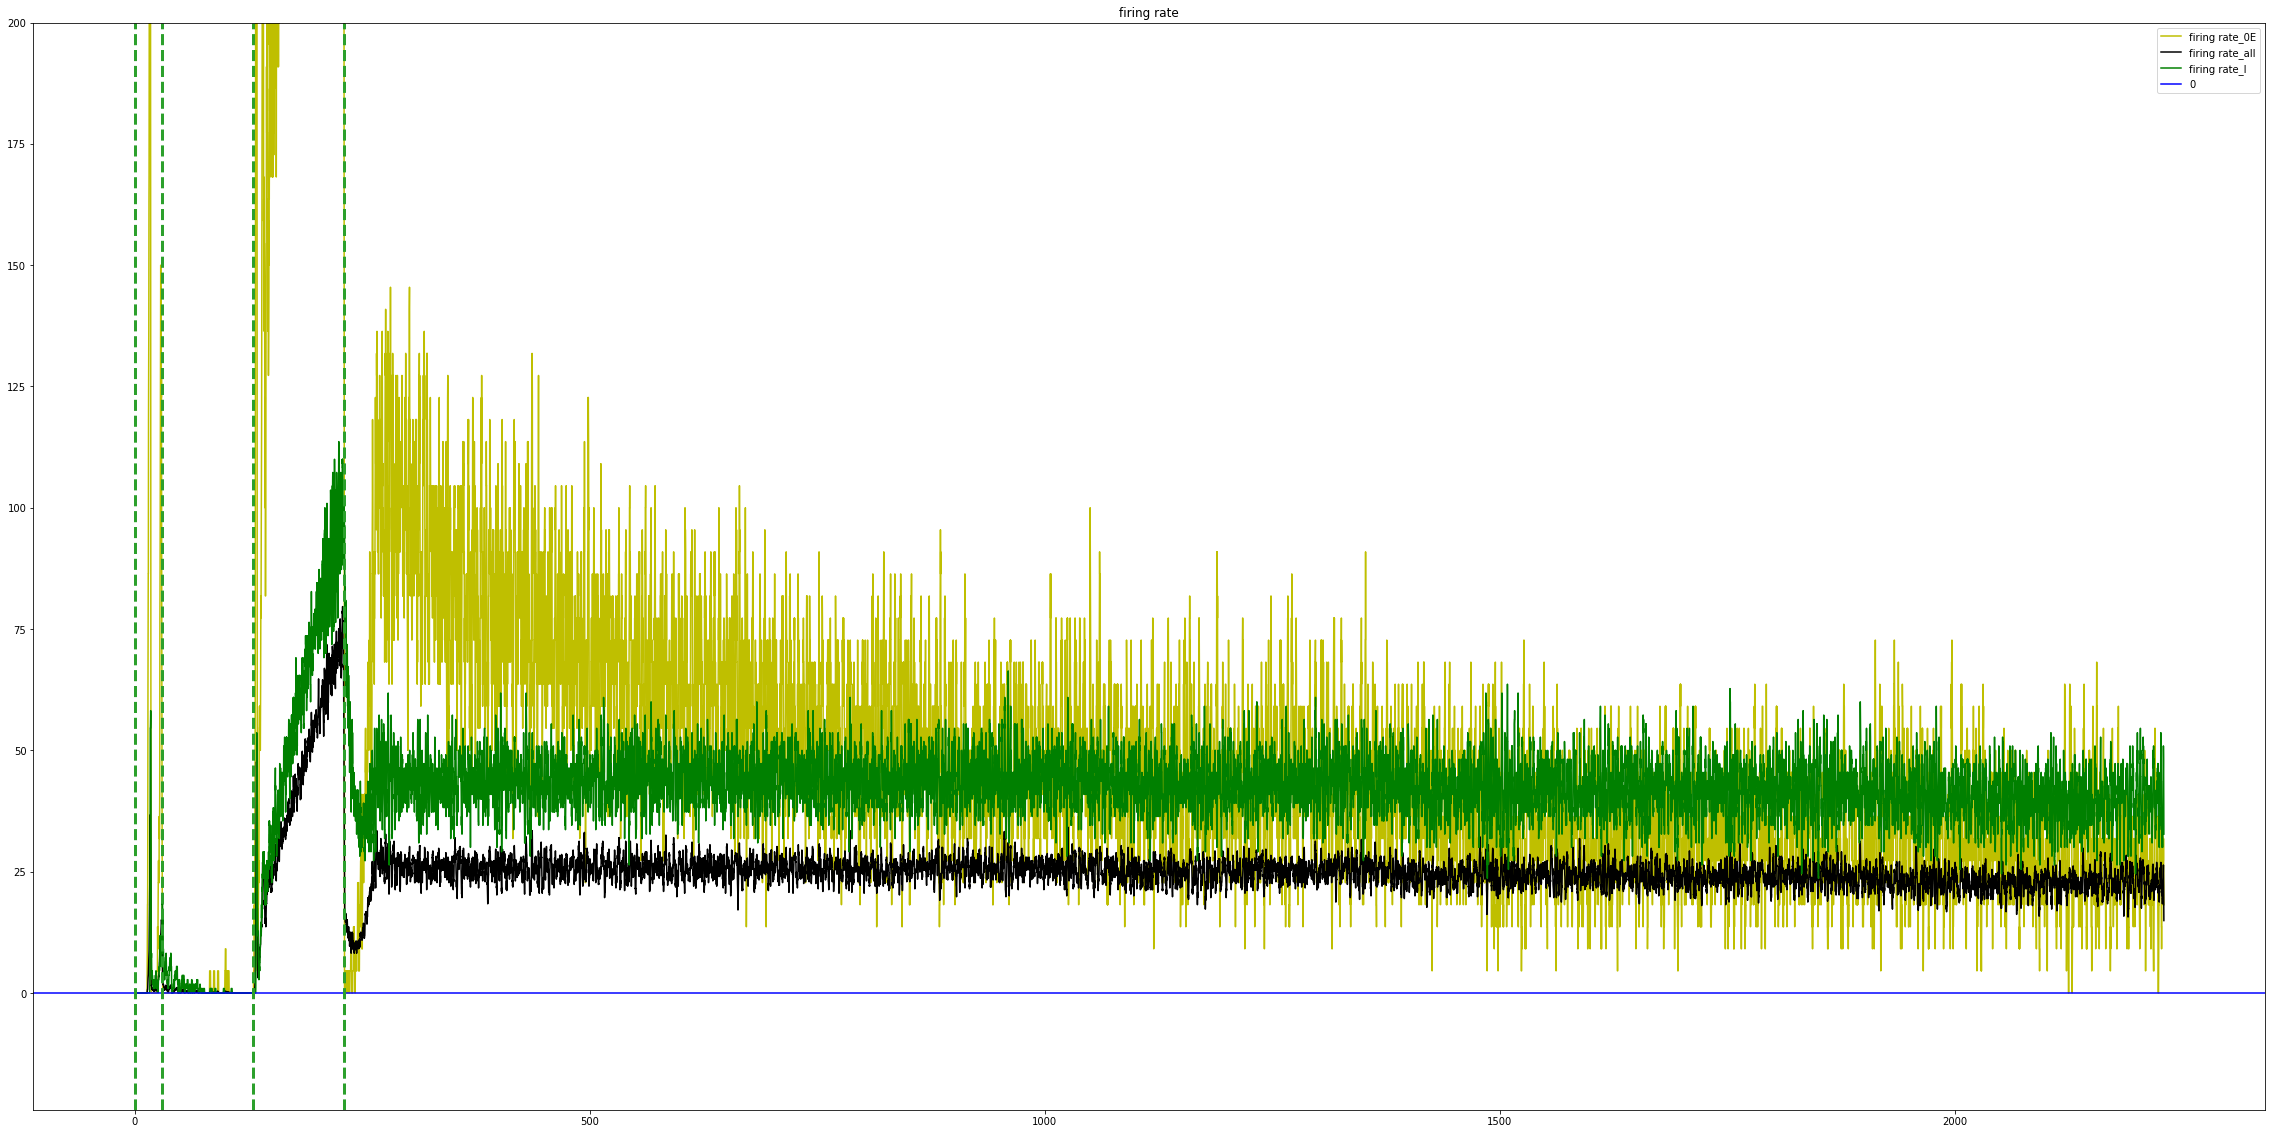

In [11]:
#firing rate
figure(figsize=(40,20))
plot(ratemon_E[0].t/ms,ratemon_E[0].smooth_rate(window='flat', width=1*ms)/Hz,c="y",label="firing rate_0E")
plot(ratemon_G.t/ms,ratemon_G.smooth_rate(window='flat', width=1*ms)/Hz,c="k",label="firing rate_all")
plot(ratemon_I.t/ms,ratemon_I.smooth_rate(window='flat', width=1*ms)/Hz,c="g",label="firing rate_I")

# axhline(y=500,color="r",label="max")
axhline(y=0,color="b",label="0")
axvline(dec_time_1/ms, ls='--', c='C2', lw=3)
axvline((dec_time_1+sti_time_1)/ms, ls='--', c='C2', lw=3)
axvline((dec_time_1+sti_time_1+mem_time_1+dec_time_2)/ms, ls='--', c='C2', lw=3)
axvline((dec_time_1+sti_time_1+mem_time_1+dec_time_2+sti_time_2)/ms, ls='--', c='C2', lw=3)
# axvline((dec_time_1+sti_time_1+mem_time_1+dec_time_2+sti_time_2)/ms+50, ls='--', c='C2', lw=3)

ylim(ymax=200)
plt.title("firing rate")
legend()


将前面的剧烈上升给去掉(confusing)

INFO       width adjusted from 2. ms to 2.1 ms [brian2.monitors.ratemonitor.adjusted_width]


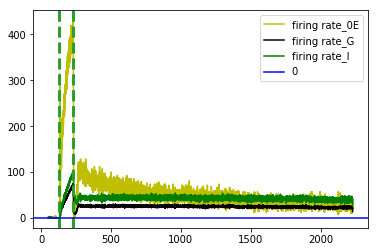

In [12]:
plot(ratemon_E[0].t[500:]/ms,ratemon_E[0].smooth_rate(window='flat', width=2*ms)[500:]/Hz,c="y",label="firing rate_0E")
plot(ratemon_G.t[500:]/ms,ratemon_G.smooth_rate(window='flat', width=2*ms)[500:]/Hz,c="k",label="firing rate_G")
plot(ratemon_I.t[500:]/ms,ratemon_I.smooth_rate(window='flat', width=2*ms)[500:]/Hz,c="g",label="firing rate_I")
axvline((dec_time_1+sti_time_1+mem_time_1+dec_time_2)/ms, ls='--', c='C2', lw=3)
axvline((dec_time_1+sti_time_1+mem_time_1+dec_time_2+sti_time_2)/ms, ls='--', c='C2', lw=3)
axhline(y=0,color="b",label="0")
legend()

steady state

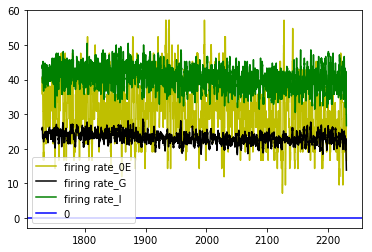

In [13]:
plot(ratemon_E[0].t[-5000:]/ms,ratemon_E[0].smooth_rate(window='flat', width=2*ms)[-5000:]/Hz,c="y",label="firing rate_0E")
plot(ratemon_G.t[-5000:]/ms,ratemon_G.smooth_rate(window='flat', width=2*ms)[-5000:]/Hz,c="k",label="firing rate_G")
plot(ratemon_I.t[-5000:]/ms,ratemon_I.smooth_rate(window='flat', width=2*ms)[-5000:]/Hz,c="g",label="firing rate_I")

axhline(y=0,color="b",label="0")
legend()

spike train

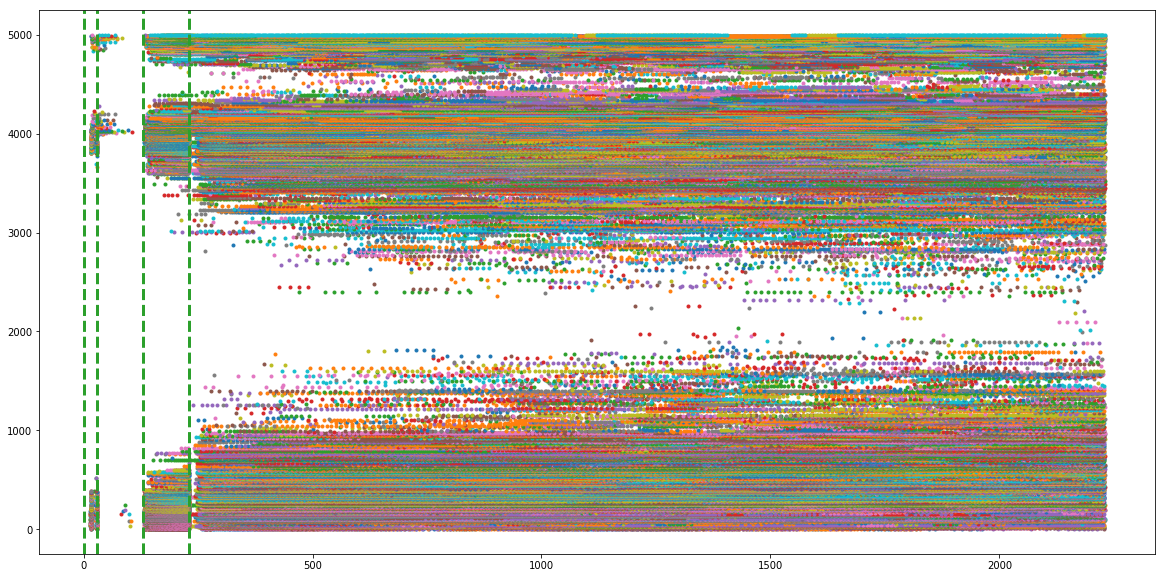

In [14]:
train=spikemon_G.spike_trains()
figure(figsize=(20,10))
for i in range(len(train)):
    plot(train[i]/ms,ones(len(train[i]))*i,'.')

axvline(dec_time_1/ms, ls='--', c='C2', lw=3)
axvline((dec_time_1+sti_time_1)/ms, ls='--', c='C2', lw=3)
axvline((dec_time_1+sti_time_1+mem_time_1+dec_time_2)/ms, ls='--', c='C2', lw=3)
axvline((dec_time_1+sti_time_1+mem_time_1+dec_time_2+sti_time_2)/ms, ls='--', c='C2', lw=3)

Coefficient of variation of interspike interval during persistent activity

In [33]:
#interval[0]就是第0个neuron在persistant acitivity时候的ISI
interval = [np.array([]) for i in range(NE+NI)] 
for i in range(NE+NI):
    temp = []
    for j in range(len(train[i])-1):
        #要保证是在persistant的过程中，认为sti_time的100ms后就是persistant了
        if (train[i][j]/ms > (dec_time_1+sti_time_1+mem_time_1+dec_time_2+sti_time_2)/ms + 800):
            temp.append((train[i][j+1] - train[i][j])/ms)
            interval[i] = asarray(temp)#转成numpy 的 array
            

占所有fire的neuron的0.812850


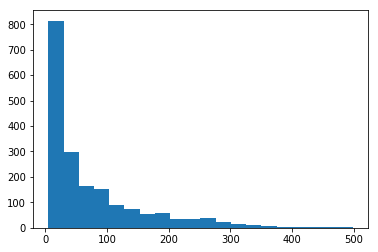

In [42]:
low = 4
count = [interval[i].size for i in range(NE+NI)]
count = asarray(count)
hist(count[count>low],bins=20)
temp = len(count[count>low])/len(count[count>0])
print("占所有fire的neuron的%f"%temp)
plt.show()

the size of included neurons is 1885


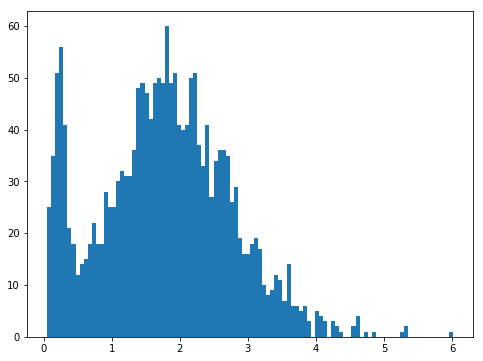

In [43]:
mean = []
std_dev = []
CV=[]
included = [] #记录了有哪些neuron被算了进去
for i in range(NE+NI):
    if interval[i].size > low:
        mean.append(np.mean(interval[i]))
        std_dev.append(np.std(interval[i]))
        included.append(i)
CV=asarray(std_dev)/asarray(mean)
included = asarray(included)
print("the size of included neurons is %d"%len(included))

fig = plt.figure(figsize=(8,6))
plt.hist(CV,bins=100)
plt.show()

firing rate between the group (how the curve evolves)

external input对于第0个population的概率最大，对应角度是0.所有的角度是 from$-\pi$ to $\pi$

<IPython.core.display.Javascript object>


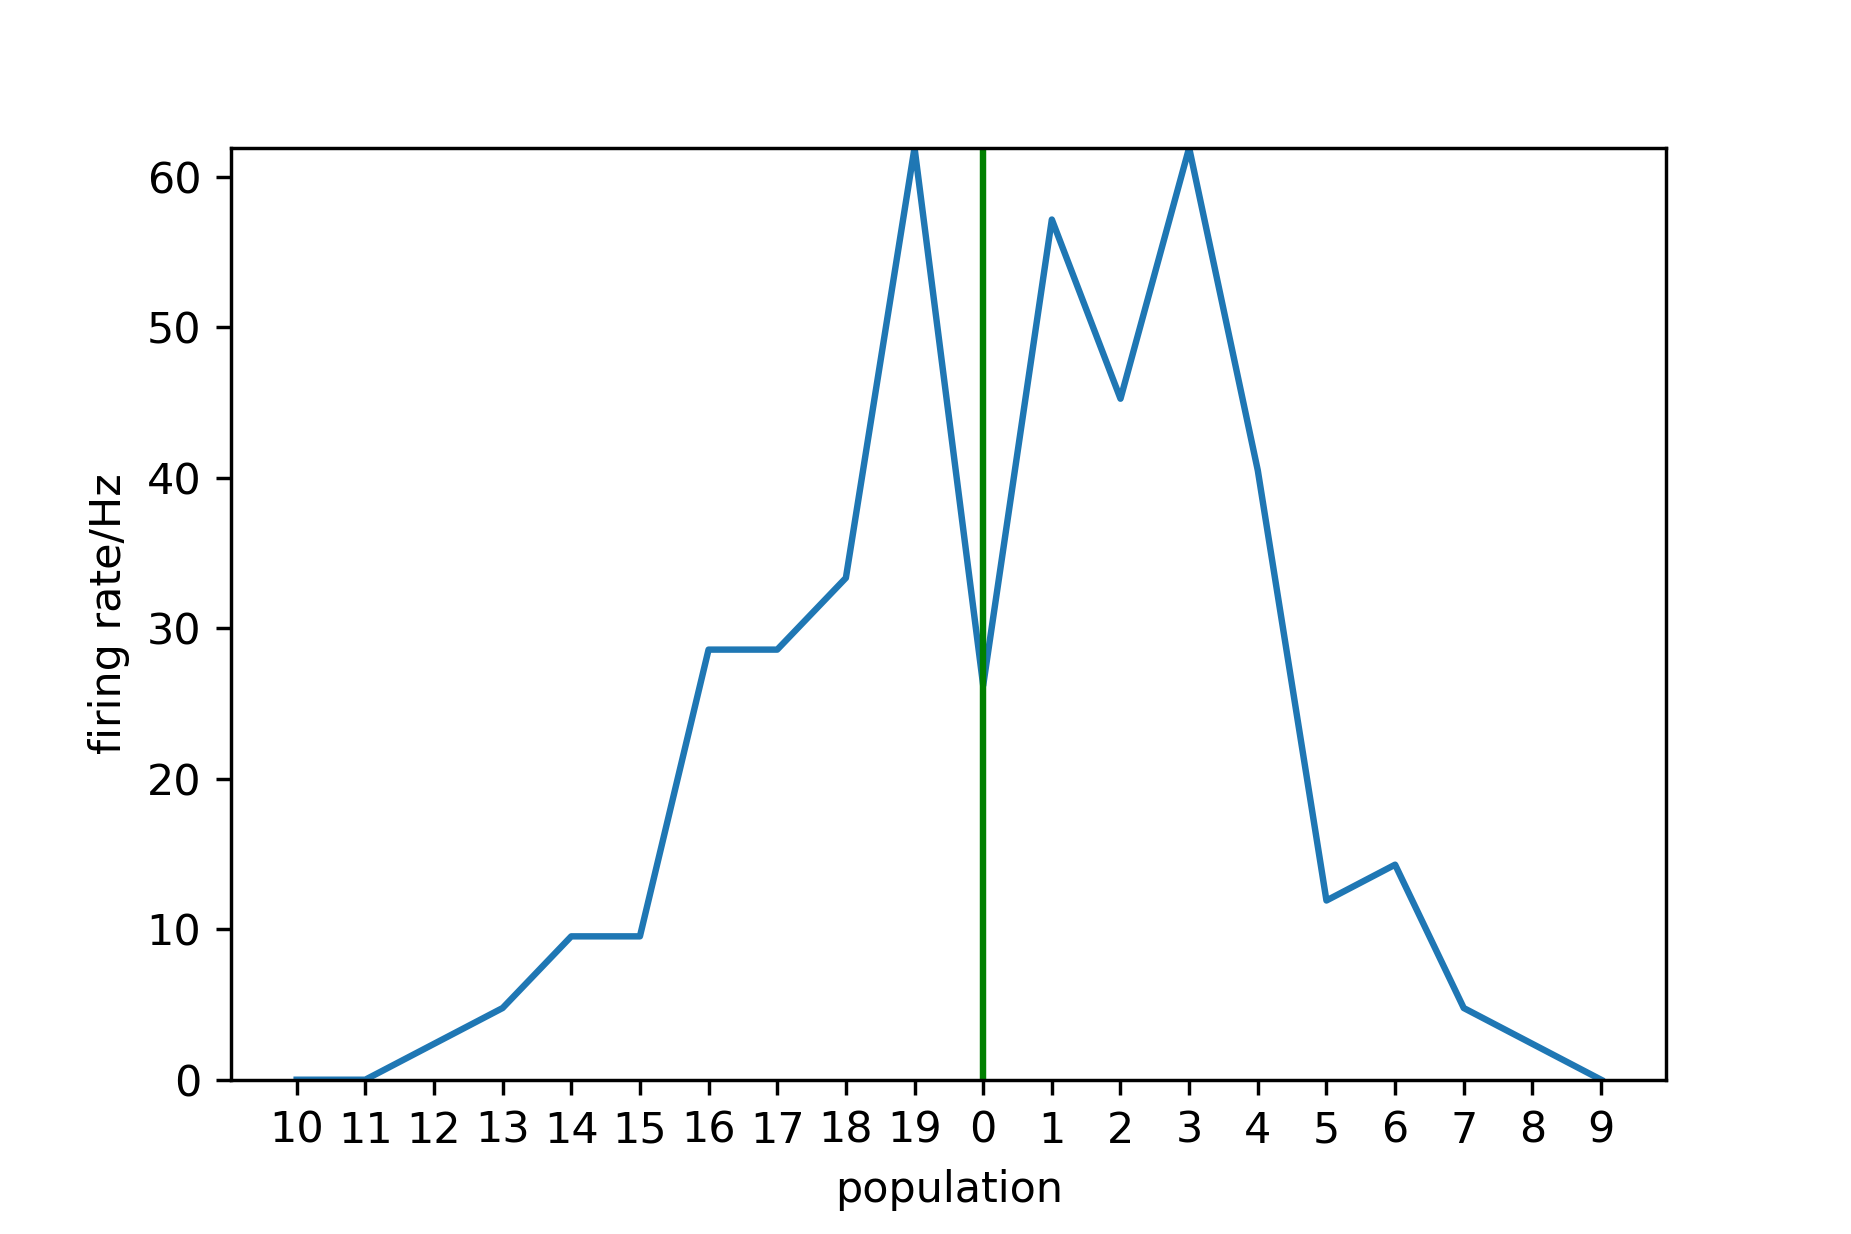

In [57]:
%matplotlib notebook 
from matplotlib.animation import FuncAnimation

xdata = range(N)

fig,ax = plt.subplots(1)
line, = ax.plot(xdata,xdata)
# fig = plt.figure()
# ax = plt.axes
# line = plt.plot(xdata,xdata)
plt.xlabel("population")
plt.ylabel("firing rate/Hz")

r = int(N/2)#要将population0(实际上是整个图像)向右平移的距离
axvline(x=r,color="g",label="0")
def animate(t):
    ydata = [ratemon_E[i].smooth_rate(window='flat', width=2*ms)[t] for i in range(N)]
    ydata = np.roll(ydata,r)#将0放在靠中间位置,这里对y坐标操作
    line.set_ydata(ydata)
    ax.set_ylim(np.min(ydata), np.max(ydata))

def init():
#     ax.set_ylim(0,60)
    plt.xticks(xdata,np.roll(xdata,r))    #将0放在靠中间位置，这里对x坐标操作
    return line

#ratemon_G.smooth_rate(window='flat', width=2*ms)[这里每增加1就是增加0.1ms]
#观察的时间点
step = 10 # 对应1ms
start_time = dec_time_1+sti_time_1+mem_time_1+dec_time_2-50*ms
end_time = dec_time_1+sti_time_1+mem_time_1+dec_time_2+sti_time_2+mem_time_2
#从sti_time_2开始观察(开始给stimulus_2的时候)
steps = np.arange(int(start_time*10/ms),int((end_time)*10/ms),step)
ani = FuncAnimation(fig, animate, steps, init_func=init, interval=1, blit=True)
plt.show()

In [19]:
%matplotlib inline
#换回原来的模式

# Test

In [20]:
#test的neuron
s=included[CV<0.2][-3]

In [26]:
print(s)
print(interval[s])
np.std(interval[s])/np.mean(interval[s])

4944
[4.7 4.7 4.3 4.1 3.9 3.7 4.1 3.5 3.5 4.6 3.3 3.7 3.8 3.4 3.  3.6 2.9 3.4
 3.1 3.  3.1 3.2 3.2 3.7 3.3 3.8 4.2 4.  4.2 4.3 4.2 4.5 4.  4.8 5.3 5.4]


0.16359641720136775

No handles with labels found to put in legend.


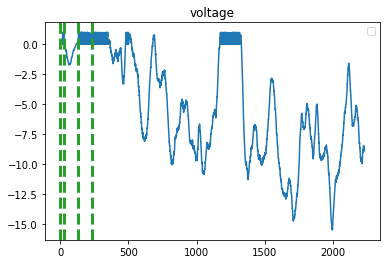

In [22]:
#voltage(主要看neuron0)
figure()
plot(statemon_G.t/ms, statemon_G.v[s])
plt.title("voltage")
axvline(dec_time_1/ms, ls='--', c='C2', lw=3)
axvline((dec_time_1+sti_time_1)/ms, ls='--', c='C2', lw=3)
axvline((dec_time_1+sti_time_1+mem_time_1+dec_time_2)/ms, ls='--', c='C2', lw=3)
axvline((dec_time_1+sti_time_1+mem_time_1+dec_time_2+sti_time_2)/ms, ls='--', c='C2', lw=3)
legend()

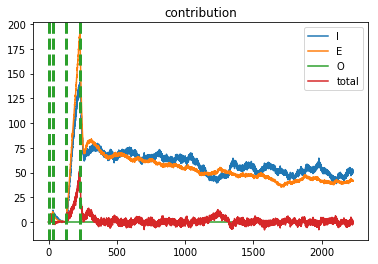

In [23]:
figure()
total=-statemon_G.v[s]+statemon_G_con_E.con_E[s]-statemon_G_con_I.con_I[s]+statemon_G_con_O.con_O[s]
plot(statemon_G_con_I.t/ms, statemon_G_con_I.con_I[s], label='I')
plot(statemon_G_con_E.t/ms, statemon_G_con_E.con_E[s], label='E')
plot(statemon_G_con_O.t/ms, statemon_G_con_O.con_O[s], label='O')
plot(statemon_G_con_O.t/ms,total,label="total")
axvline(dec_time_1/ms, ls='--', c='C2', lw=3)
axvline((dec_time_1+sti_time_1)/ms, ls='--', c='C2', lw=3)
axvline((dec_time_1+sti_time_1+mem_time_1+dec_time_2)/ms, ls='--', c='C2', lw=3)
axvline((dec_time_1+sti_time_1+mem_time_1+dec_time_2+sti_time_2)/ms, ls='--', c='C2', lw=3)
plt.title("contribution")
legend()


CV比较小的时候EI仍是balance的